In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
!pip install grad-cam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 60.5 MB/s eta 0:00:0000:0100:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for grad-cam: filename=grad_cam-1.5.4-py3-none-any.whl size=39648 sha256=34b7cf475edfdc9bb91fc7010b60e84bc9e607bb766f04d8c8e3e181994b2e25
  Stored in directory: /root/.cache/pip/wheels/50/b0/82/1f97b5348c7fe9f0ce0ba18497202cafa5dec4562bd5292680
Successfully built grad-cam


In [3]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import transforms, models
from sklearn.metrics import accuracy_score
from tqdm import tqdm
from PIL import Image
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pytorch_grad_cam import ScoreCAM
from pytorch_grad_cam.utils.image import show_cam_on_image

In [4]:

# 1. Dataset
class CelebADataset(Dataset):
    def __init__(self, root_dir, attr_file, transform=None):
        self.root_dir = root_dir
        self.attr_file = attr_file
        self.transform = transform

        # Read attribute file
        self.attrs = pd.read_csv(attr_file, delim_whitespace=True, skiprows=1)
        self.attrs = self.attrs[['Smiling']]  # Select only 'Smiling' attribute
        self.attrs.replace(to_replace=-1, value=0, inplace=True)  # Replace -1 with 0
        self.images = self.attrs.index.tolist()  # Image names

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.images[idx])
        image = Image.open(img_name)
        if self.transform:
            image = self.transform(image)
        label = self.attrs.iloc[idx].values[0]
        return image, label


In [5]:

# 2. Transformations
transform = transforms.Compose([
    # transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [6]:

# 3. Dataset and DataLoader
root_dir = '/kaggle/input/celebamaskhq/CelebAMask-HQ/CelebA-HQ-img'  # Update with your path
attr_file = '/kaggle/input/celebamaskhq/CelebAMask-HQ/CelebAMask-HQ-attribute-anno.txt'  # Update with your path
dataset = CelebADataset(root_dir, attr_file, transform=transform)


<ipython-input-4-051902f1e52e>:9: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  self.attrs = pd.read_csv(attr_file, delim_whitespace=True, skiprows=1)


In [26]:
print(dataset.attrs)

           Smiling
0.jpg            1
1.jpg            1
2.jpg            1
3.jpg            1
4.jpg            0
...            ...
29995.jpg        1
29996.jpg        1
29997.jpg        0
29998.jpg        0
29999.jpg        1

[30000 rows x 1 columns]


In [7]:

# # Split dataset into train and validation
# train_size = int(0.8 * len(dataset))
# val_size = len(dataset) - train_size
# train_data, val_data = random_split(dataset, [train_size, val_size])

# train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
# val_loader = DataLoader(val_data, batch_size=32, shuffle=False)


In [8]:
# 4. ResNet Model
class ResNetSmiling(nn.Module):
    def __init__(self):
        super(ResNetSmiling, self).__init__()
        self.base_model = models.resnet18(pretrained=True)  # Load pretrained ResNet18
        num_features = self.base_model.fc.in_features
        self.base_model.fc = nn.Sequential(
            nn.Linear(num_features, 1),
            nn.Sigmoid()  # For binary classification
        )

    def forward(self, x):
        return self.base_model(x)
        

In [9]:

# # Initialize the model
# model = ResNetSmiling().to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))


In [10]:

# # 5. Training Loop
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# criterion = nn.BCELoss()
# optimizer = optim.Adam(model.parameters(), lr=0.001)

# best_val_loss = float('inf')
# epochs = 5


In [11]:
# device

In [12]:

# for epoch in range(epochs):
#     # Training phase
#     model.train()
#     train_loss = 0.0
#     print(f"Epoch {epoch+1}/{epochs}")
#     for images, labels in tqdm(train_loader, desc="Training", leave=False):
#         images, labels = images.to(device), labels.to(device).float()
#         optimizer.zero_grad()
#         outputs = model(images).squeeze()
#         loss = criterion(outputs, labels)
#         loss.backward()
#         optimizer.step()
#         train_loss += loss.item()

#     # Validation phase
#     model.eval()
#     val_loss = 0.0
#     y_true = []
#     y_pred = []
#     for images, labels in tqdm(val_loader, desc="Validating", leave=False):
#         with torch.no_grad():
#             images, labels = images.to(device), labels.to(device).float()
#             outputs = model(images).squeeze()
#             loss = criterion(outputs, labels)
#             val_loss += loss.item()

#             preds = (outputs > 0.5).float()
#             y_true.extend(labels.cpu().numpy())
#             y_pred.extend(preds.cpu().numpy())

#     # Calculate metrics
#     train_loss /= len(train_loader)
#     val_loss /= len(val_loader)
#     val_accuracy = accuracy_score(y_true, y_pred)

#     print(f"Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")

#     # Save the best model
#     if val_loss < best_val_loss:
#         best_val_loss = val_loss
#         torch.save(model.state_dict(), 'best_resnet_smiling.pth')
#         print(f"Saved Best Model at Epoch {epoch+1}")

In [13]:
# 6. Load Best Model into a New Variable
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
loaded_model = ResNetSmiling().to(device)
# loaded_model.load_state_dict(torch.load('best_resnet_smiling.pth'))
loaded_model.load_state_dict(torch.load('/kaggle/input/resnet-smiling-model/best_resnet_smiling.pth', map_location=torch.device('cpu')))
loaded_model.eval()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 161MB/s] 
<ipython-input-13-87122c860d37>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is poss

ResNetSmiling(
  (base_model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, 

In [14]:

# 7. Predict for a Single Image
def predict_image(image_path, model):
    model.eval()
    target_image = Image.open(image_path).convert('RGB')
    transform = transforms.Compose([
        # transforms.Resize((128, 128)),
        transforms.ToTensor(),
        # transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        
    ])
    image_tensor = transform(target_image).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(image_tensor).item()
        prediction = 1 if output > 0.5 else 0
        confidence = output if prediction == 1 else 1 - output

    return prediction, confidence


In [15]:

# Example Usage
example_image_path = '/kaggle/input/celebamaskhq/CelebAMask-HQ/CelebA-HQ-img/10021.jpg'  # Update with the path to an example image
prediction, confidence = predict_image(example_image_path, loaded_model)
print(f"Prediction: {'Smiling' if prediction == 1 else 'Not Smiling'}, Confidence: {confidence:.4f}")


Prediction: Smiling, Confidence: 1.0000


In [24]:
# 8. Generate Heatmap
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam import GradCAM, GradCAMPlusPlus

def generate_heatmap(image_path, model, target_layer):
    model.eval()
    target_image = Image.open(image_path).convert('RGB')
    transform = transforms.Compose([
        # transforms.Resize((128, 128)),
        transforms.ToTensor(),
        # transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
        transforms.Normalize(
         mean=[0.485, 0.456, 0.406], 
         std=[0.229, 0.224, 0.225]
        )
    ])
    image_tensor = transform(target_image).unsqueeze(0).to(device)

    # Initialize GradCAM
    cam = GradCAM(model=model, target_layers=[target_layer])
    grayscale_cam = cam(input_tensor=image_tensor)[0, :]  # Generate CAM

    # Convert tensor to image format for visualization
    rgb_image = np.array(target_image) / 255.0
    heatmap = show_cam_on_image(rgb_image, grayscale_cam, use_rgb=True)

    # Show heatmap
    plt.figure(figsize=(6, 6))
    plt.imshow(heatmap)
    plt.axis('off')
    plt.title('GradCAM Heatmap')
    plt.show()


In [38]:
df = dataset.attrs
df

Smiling
0.jpg            1
1.jpg            1
2.jpg            1
3.jpg            1
4.jpg            0
...            ...
29995.jpg        1
29996.jpg        1
29997.jpg        0
29998.jpg        0
29999.jpg        1

[30000 rows x 1 columns]

In [39]:
df = df.reset_index().rename(columns={'index': 'img'})
df

img  Smiling
0          0.jpg        1
1          1.jpg        1
2          2.jpg        1
3          3.jpg        1
4          4.jpg        0
...          ...      ...
29995  29995.jpg        1
29996  29996.jpg        1
29997  29997.jpg        0
29998  29998.jpg        0
29999  29999.jpg        1

[30000 rows x 2 columns]

In [40]:
df = df.reset_index().rename(columns={'index': 'idx'})
df

idx        img  Smiling
0          0      0.jpg        1
1          1      1.jpg        1
2          2      2.jpg        1
3          3      3.jpg        1
4          4      4.jpg        0
...      ...        ...      ...
29995  29995  29995.jpg        1
29996  29996  29996.jpg        1
29997  29997  29997.jpg        0
29998  29998  29998.jpg        0
29999  29999  29999.jpg        1

[30000 rows x 3 columns]

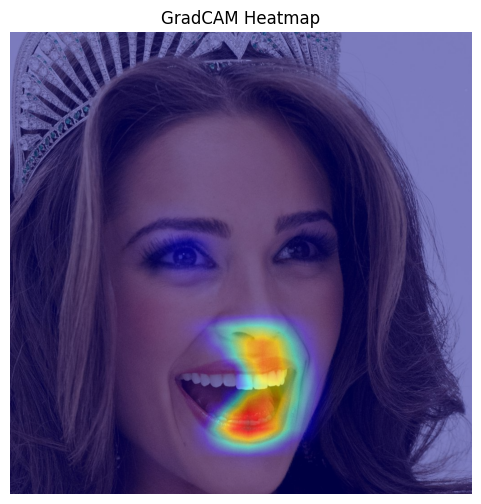

Prediction: Smiling, Confidence: 0.9996
Groundtruth: Smiling


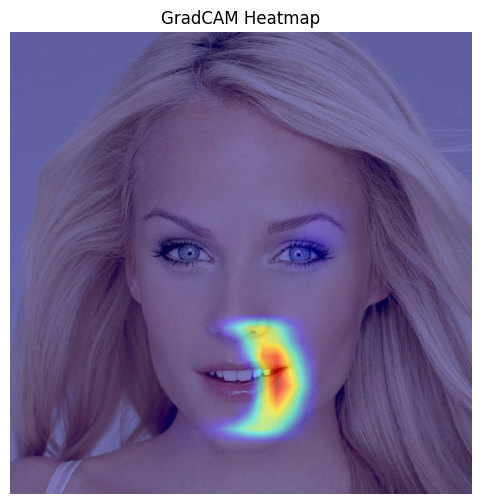

Prediction: Smiling, Confidence: 0.6194
Groundtruth: Smiling


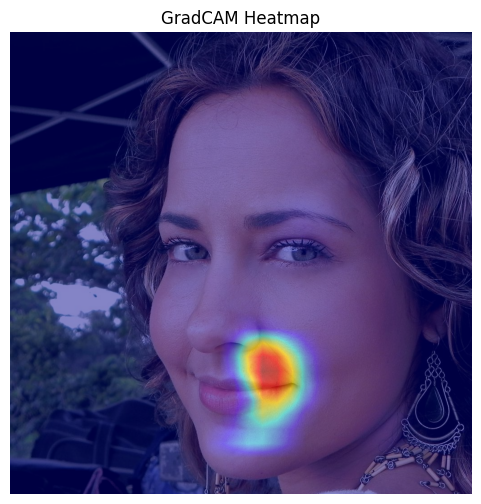

Prediction: Smiling, Confidence: 0.7939
Groundtruth: Smiling


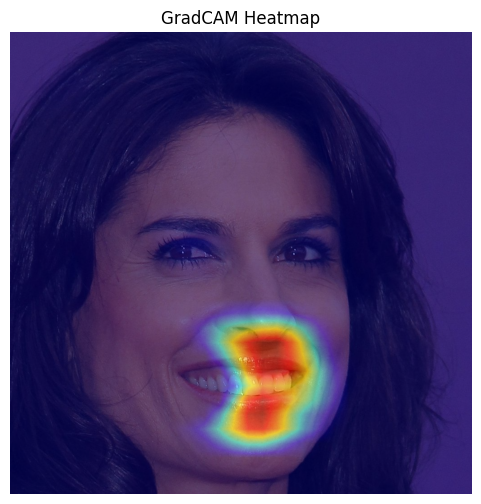

Prediction: Smiling, Confidence: 1.0000
Groundtruth: Smiling


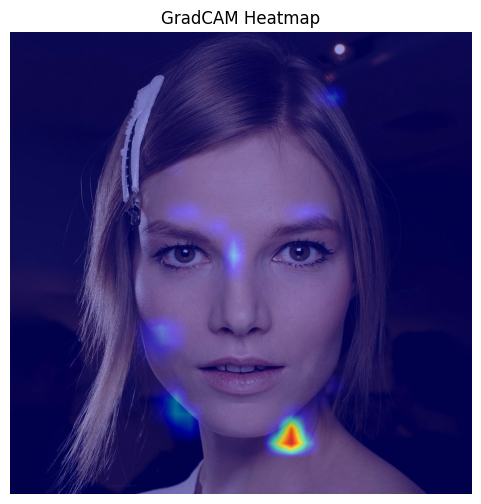

Prediction: Not Smiling, Confidence: 0.9907
Groundtruth: Not Smiling


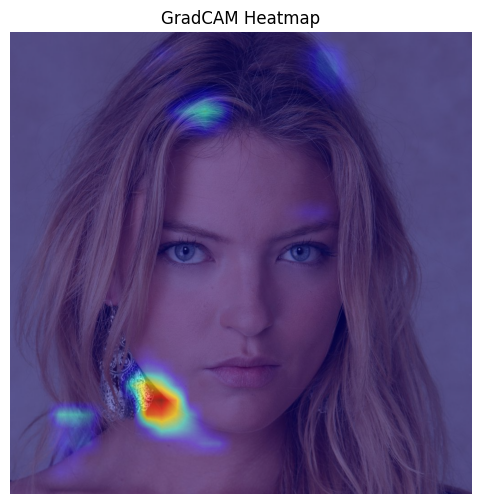

Prediction: Not Smiling, Confidence: 0.9874
Groundtruth: Not Smiling


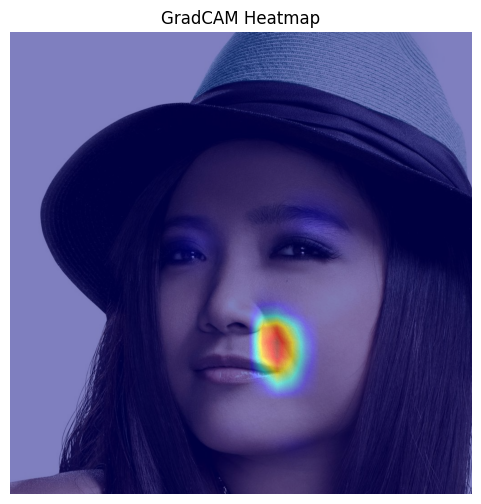

Prediction: Not Smiling, Confidence: 0.9498
Groundtruth: Not Smiling


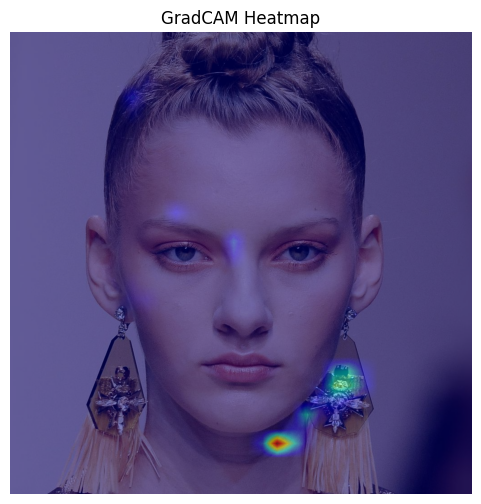

Prediction: Not Smiling, Confidence: 0.9955
Groundtruth: Not Smiling


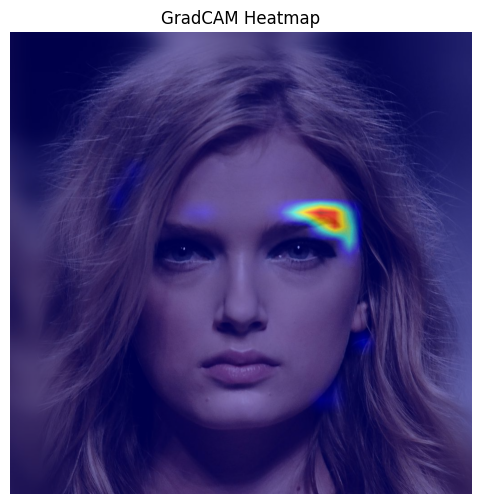

Prediction: Not Smiling, Confidence: 0.9897
Groundtruth: Not Smiling


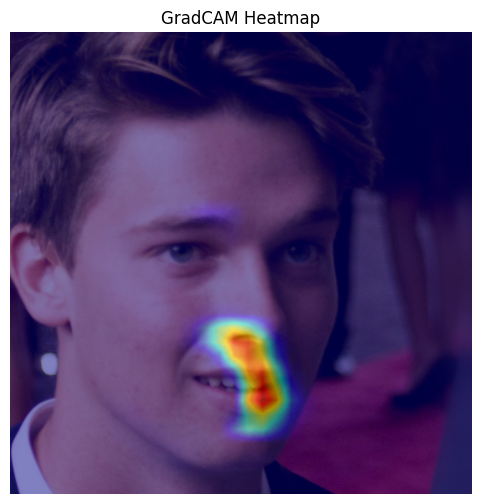

Prediction: Not Smiling, Confidence: 0.7901
Groundtruth: Not Smiling


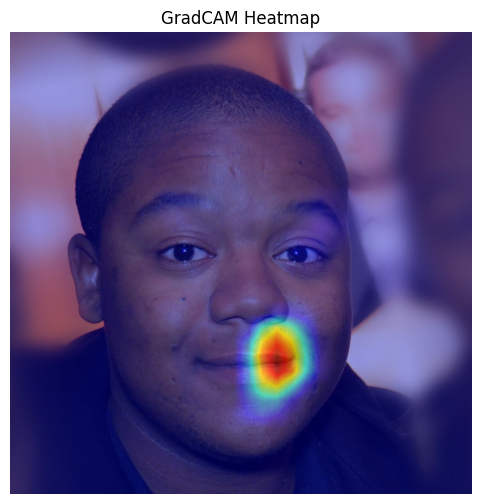

Prediction: Not Smiling, Confidence: 0.5994
Groundtruth: Not Smiling


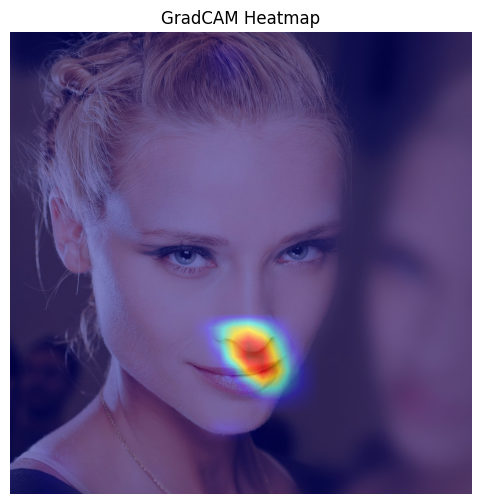

Prediction: Not Smiling, Confidence: 0.7105
Groundtruth: Not Smiling


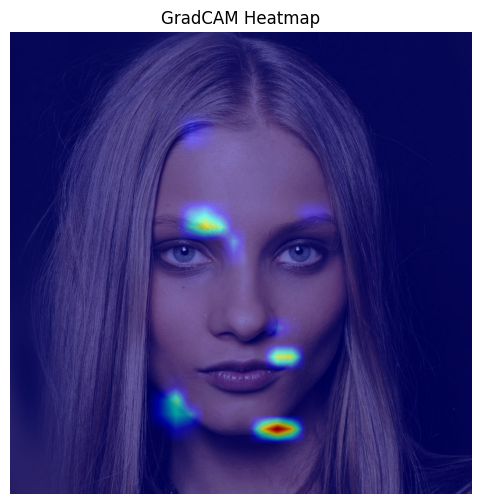

Prediction: Not Smiling, Confidence: 0.9883
Groundtruth: Not Smiling


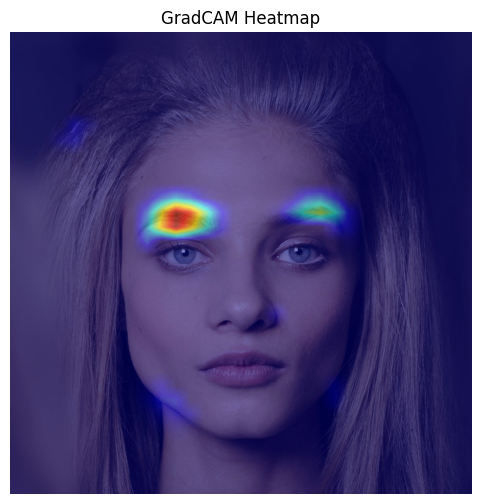

Prediction: Not Smiling, Confidence: 0.9926
Groundtruth: Not Smiling


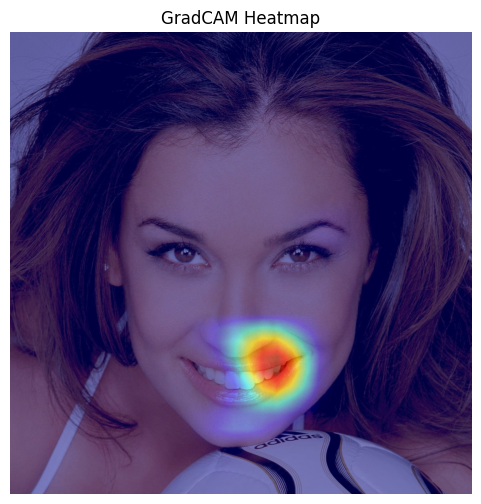

Prediction: Smiling, Confidence: 0.9998
Groundtruth: Smiling


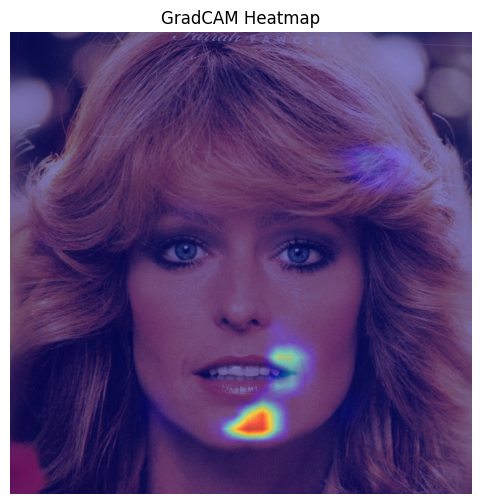

Prediction: Not Smiling, Confidence: 0.9978
Groundtruth: Not Smiling


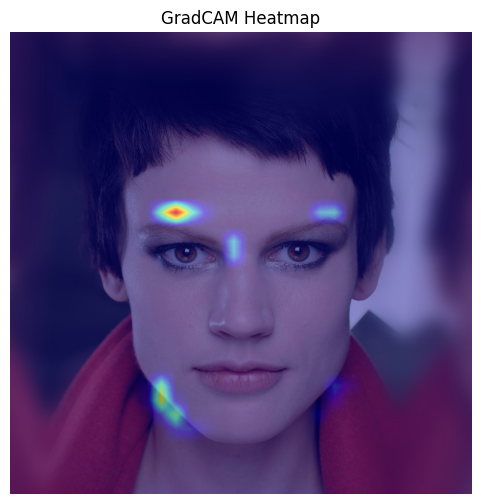

Prediction: Not Smiling, Confidence: 0.9987
Groundtruth: Not Smiling


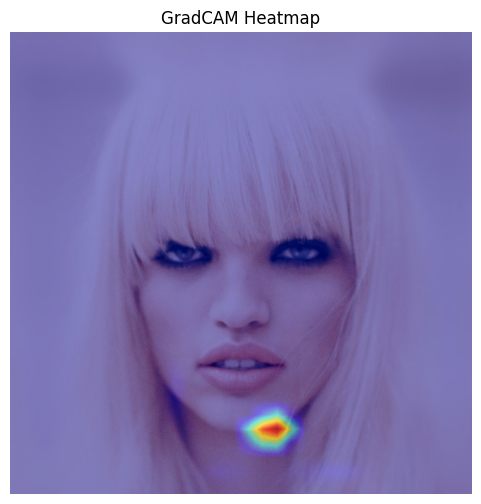

Prediction: Not Smiling, Confidence: 0.9970
Groundtruth: Not Smiling


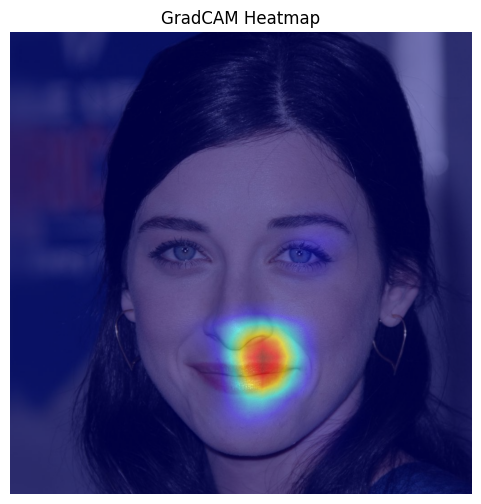

Prediction: Smiling, Confidence: 0.9948
Groundtruth: Smiling


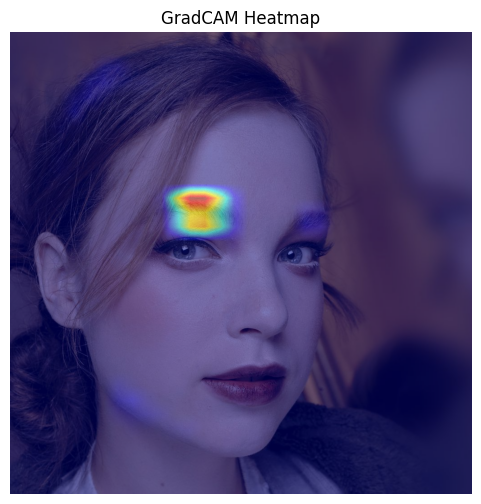

Prediction: Not Smiling, Confidence: 0.9733
Groundtruth: Not Smiling


In [45]:

for i in range(20):
    example_image_path = f'/kaggle/input/celebamaskhq/CelebAMask-HQ/CelebA-HQ-img/{i}.jpg'
    generate_heatmap(example_image_path, loaded_model, target_layer=loaded_model.base_model.layer4)
    prediction, confidence = predict_image(example_image_path, loaded_model)
    print(f"Prediction: {'Smiling' if prediction == 1 else 'Not Smiling'}, Confidence: {confidence:.4f}")
    # print(df[df['idx'] == i]['Smiling'].values)
    if df[df['idx'] == i]['Smiling'].values == 1:
        print("Groundtruth: Smiling")
    else:
        print("Groundtruth: Not Smiling")